<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Testing-Delay-In-Painting-Using-CLEAN-with-EoR-and-Foregrounds" data-toc-modified-id="Testing-Delay-In-Painting-Using-CLEAN-with-EoR-and-Foregrounds-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Testing Delay In-Painting Using CLEAN with EoR and Foregrounds</a></span><ul class="toc-item"><li><span><a href="#Setup-and-Metadata" data-toc-modified-id="Setup-and-Metadata-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup and Metadata</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Software" data-toc-modified-id="Software-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Software</a></span></li></ul></li></ul></li><li><span><a href="#Dataset-Creation" data-toc-modified-id="Dataset-Creation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset Creation</a></span><ul class="toc-item"><li><span><a href="#Flags-from-LST-Binned-HERA-IDR2.2-Data" data-toc-modified-id="Flags-from-LST-Binned-HERA-IDR2.2-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Flags from LST-Binned HERA IDR2.2 Data</a></span></li><li><span><a href="#Extract-LST-Range-Subset-and-Apply-Flags" data-toc-modified-id="Extract-LST-Range-Subset-and-Apply-Flags-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract LST Range Subset and Apply Flags</a></span></li><li><span><a href="#Load-Datasets" data-toc-modified-id="Load-Datasets-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Load Datasets</a></span><ul class="toc-item"><li><span><a href="#Raw-Datasets" data-toc-modified-id="Raw-Datasets-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Raw Datasets</a></span></li><li><span><a href="#Load-In-painted-Data" data-toc-modified-id="Load-In-painted-Data-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Load In-painted Data</a></span></li></ul></li><li><span><a href="#Spectral-Windows" data-toc-modified-id="Spectral-Windows-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Spectral Windows</a></span></li></ul></li><li><span><a href="#$\texttt{hera_pspec}$-Analysis" data-toc-modified-id="$\texttt{hera_pspec}$-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>$\texttt{hera_pspec}$ Analysis</a></span><ul class="toc-item"><li><span><a href="#$\texttt{hera_pspec}$-Functions" data-toc-modified-id="$\texttt{hera_pspec}$-Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>$\texttt{hera_pspec}$ Functions</a></span></li><li><span><a href="#Run-$\texttt{hera-pspec}$" data-toc-modified-id="Run-$\texttt{hera-pspec}$-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Run $\texttt{hera-pspec}$</a></span></li><li><span><a href="#Delay-Power-Spectra" data-toc-modified-id="Delay-Power-Spectra-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Delay Power Spectra</a></span></li><li><span><a href="#In-painting-Efficacy-Analysis" data-toc-modified-id="In-painting-Efficacy-Analysis-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>In-painting Efficacy Analysis</a></span></li></ul></li></ul></div>

<a id="sec_1"></a>

# Testing Delay In-Painting Using CLEAN with EoR and Foregrounds

Jacob Burba and the HERA Validation Team

## Setup and Metadata

### Abstract

Using simulated datasets from RIMEz of the GSM, GLEAM, and a $k^{-2}$ EoR power spectrum, we add RFI flags from the HERA-IDR2 observing season and perform a delay in-painting to fill in RFI gaps using the CLEAN algorithm.  The performance of the in-painting is determined based on the ability of the in-painted data to accurately reproduce the input data in the form of its delay power spectrum.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys, copy
import glob
import h5py
import time
import hera_cal as hc
import pyuvdata
import hera_pspec
import matplotlib.colors as plt_colors

from pathlib import Path
from datetime import datetime
from hera_cal.io import HERAData
from hera_pspec.conversions import Cosmo_Conversions
from pyuvdata import UVData, UVFlag, utils
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 12})

/lustre/aoc/projects/hera/jburba/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


### Description

Last executed: {{print(datetime.now())}}

- **Major Step Description:** Test pipeline components related to in-paitning of flags.
- **Minor Variation Description:**
  - Use RIMEz to simulate visibilities including GLEAM, eGSM, and a $P(k) = Ak^{-2}$ EoR power spectrum
  - Extract LST-binned flags from H1C IDR2.2 data
  - Apply LST-binned flags to simulated visibilities
  - Run `vis_clean` to in-paint (via frequency CLEAN) flagged visibilities
  - Run $\texttt{hera_pspec}$, with parameters based on H1C IDR2 analysis pipeline, on cleaned visibilities
  - Compare output power spectra from different time/frequency windows against input power spectra
- **Pipelines Tested:** $\texttt{vis_clean}$, $\texttt{hera_pspec}$
- **Criteria**:  
  1. The dynamic range achieved by the in-painting is a measure of how far down in amplitude, or alternatively how far out in delay, we can probe before the in-painted power spectrum deviates from the expected power spectrum by, in this case, 10\%.  For in-painting over the full range of LSTs in IDR2.2, when including the LST cuts used in the actual analysis, the dynamic range of the in-painting must exceed the dynamic range of the noise floor in the data relative to the $\tau=0\ \rm{ns}$ mode.

### Summary

The results of this validation test, in reference to the outlined criteria, are

1. In the presence of the least desirable flagging pattern, where there is a stripe of frequency channels flagged for all times in the center of the spw, the dynamic range of the in-painting relative to the $\tau=0\ \rm{ns}$ mode is $\sim10^7$.  This dynamic range exceeds the dynamic range of the noise floor relative to the $\tau=0\ \rm{ns}$ seen in analysis of IDR2.2 data.  It is important to note that the in-painting used here uses a set of optimized parameters that differ from those used in the actual IDR2.2 pipeline.  However, the purpose of this test was to show that the in-painting works in principle and this document demonstrates that it can achieve large dynamic ranges, up to $10^{11}$ in the best case tested here, that far exceed the dynamic range of the noise floor in actual data.

Some interesting behavior discovered via this test:

1. The performance of the in-painting is highly dependent upon the structure of the flags within a given spectral window.  Any frequency channels which have been flagged for all times that lie within the central 50% of the window cause significant deviations in the recovered (in-painted) power spectrum when compared to the true (unflagged) power spectrum.

2. Based on the small subset of baselines used in this test, the performance of the in-painting seems to work best for EW oriented baselines, or those with larger EW projections, and performs increasingly well with increasing basleine length.  The in-painting seems to work less well for baselines with nonzero NS components.  An in-depth look at this would require looking at more baselines than were tested here.

### Software

In [2]:
pyuvdata_version = pyuvdata.__version__
numpy_version = np.__version__

HERA software used in this validation test, with associate git commit hash:

* $\texttt{pyuvdata}$ : `{{pyuvdata_version}}`
* $\texttt{hera_cal}$ (contains ``vis_clean``) : `2e5dd382872f649266f334e9f3ded4fc4803f017`
* $\texttt{hera_pspec}$ : `{{hera_pspec.version.git_hash}}`
* $\texttt{H1C_IDR2}$ : `13b7d05cce90b86db4537038308eafb6a129187e`}

Versions of other software used in this validation test:

* $\texttt{numpy}$ : {{numpy_version}}
* $\texttt{matplotlib}$: v3.1.0

# Dataset Creation

<a id="data_paths"></a>
The raw data used for each component of the simulated visibilities can be found within

```/lustre/aoc/projects/hera/Validation/```

in the following subdirectories:

* EoR: `hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5`
* GLEAM: `hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5`
* eGSM: `hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5`

To speed up analysis, only the data with baselines $|b| \leq 30$ m in length and within a usable range of LSTs based on availablility of flags from HERA IDR2.2 data have been subdivided up into three LST hour ranges (see the subsection below [Load Flags from UVFlag Object](#rfi_flags)).  The following subsections outline the process of
 - Getting flags from HERA IDR2.2 data
 - Subdividing the master datasets into LST hour ranges

## Flags from LST-Binned HERA IDR2.2 Data

<a id="rfi_flags"></a>

The flags used here were obtained from HERA IDR2.2 LST binned data available at

`/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/LSTBIN/one_group/grp1/`

There is roughly 12 hours of LST binned IDR2.2 data with flags for a large number of baselines.  To obtain the flags used here, all available LST binned datasets were loaded to get the full 12 hours of LST worth of flags for a single baseline.  These flags were checked against the flags from other baseline lengths and types in the LST binned data and were seen to be very similar and thus representative of the typical flags from real data.  There is a significant number of integrations from 0 to ~0.7 hours and ~11.4 to 12 hours which are completely flagged and thus unuseable for in-painting.  The remaining flags inside the LST hour range of 0.7 to 11.4 hours were saved to

`/lustre/aoc/projects/hera/Validation/test-3.1.0/flags/idr2.2_flags.LSThrs_*-*.uvflag`

In [3]:
idr2_df_path = Path('/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/LSTBIN/one_group/grp1/')
idr2_filepaths = sorted(idr2_df_path.glob('zen.grp1*LST*.uvh5'))
bls = [(23, 52)]
polarizations = ['xx']

uvd_idr2 = UVData()
uvd_idr2.read(idr2_filepaths, bls=bls, polarizations=polarizations)

idr2_lsts_rad = np.unique(uvd_idr2.lst_array)
idr2_lsts_hrs = idr2_lsts_rad * 12.0 / np.pi

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HER

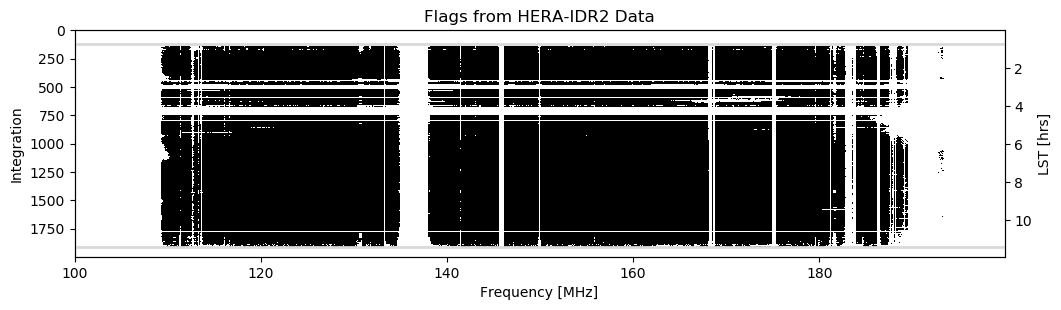

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
cax = plt.imshow(uvd_idr2.flag_array[:, 0, :, 0].astype('int'),
                 extent=[uvd_idr2.freq_array[0, 0] / 1e6,
                         uvd_idr2.freq_array[0, -1] / 1e6, 
                         uvd_idr2.Ntimes,
                         0],
                 aspect='auto',
                 cmap='bone')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Integration')
plt.title('Flags from HERA-IDR2 Data')

ax2 = ax.twinx()
tick_inds = ax.get_yticks()
ax2.set_ylim([idr2_lsts_hrs.min(), idr2_lsts_hrs.max()])
ax2.invert_yaxis()
ax2.hlines([idr2_lsts_hrs[124], idr2_lsts_hrs[1905]],
           uvd_idr2.freq_array[0, 0] / 1e6,
           uvd_idr2.freq_array[0, -1] / 1e6,
           linestyle='-', color='0.85', lw=2)
ax2.set_xlim([uvd_idr2.freq_array[0, 0] / 1e6, uvd_idr2.freq_array[0, -1] / 1e6])
ax2.set_ylabel('LST [hrs]');

<a id="figure_1"></a>
**Figure 1** | Flags from LST binned HERA-IDR2.2 data for all available LSTs.  Flagged and unflagged samples are plotted in white and black, respectively.  The range of LSTs chosen to pull flags from lies in between the solid grey lines.

There are several integrations at the beginning and the end of these observations that are unusable because they are fully flagged.  The LST hour range of 0.74 - 11.40 hours, bounded by the solid black lines in [Figure 1](#figure_1) above, avoids almost all of the fully flagged integrations at the beginning and end of the file.

In [8]:
flag_data_path = Path('/lustre/aoc/projects/hera/Validation/test-3.1.0/flags/')

lst_inds = [124, 1905]
LSThr_str = 'LSThrs_{:.2f}-{:.2f}.uvflag'.format(idr2_lsts_hrs[lst_inds[0]],
                                                 idr2_lsts_hrs[lst_inds[1]])
times_to_keep = np.unique(uvd_idr2.time_array)[lst_inds[0]:lst_inds[1] + 1]
print('Range = {} - {} hrs'.format(idr2_lsts_hrs[lst_inds[0]],
                                       idr2_lsts_hrs[lst_inds[1]]))
print('Range = {} - {} rad'.format(idr2_lsts_hrs[lst_inds[0]] * np.pi / 12.0,
                                       idr2_lsts_hrs[lst_inds[1]] * np.pi / 12.0))
print('Array indices = {} - {}'.format(lst_inds[0], lst_inds[1]))
uvd_idr2_select = uvd_idr2.select(times=times_to_keep, inplace=False)
uvf = UVFlag(uvd_idr2_select, mode='flag', copy_flags=True)
if not (flag_data_path / ('idr2.2_flags.' + LSThr_str)).exists():
    uvf.write(flag_data_path / ('idr2.2_flags.' + LSThr_str), clobber=False)
else:
    print('File already exists at {}'.format(flag_data_path / ('idr2.2_flags.' + LSThr_str)))
print('')

Range = 0.7447657028913257 - 11.3988035892323 hrs
Range = 0.19497920507075228 - 2.984199801303763 rad
Array indices = 124 - 1905
File already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/flags/idr2.2_flags.LSThrs_0.74-11.40.uvflag



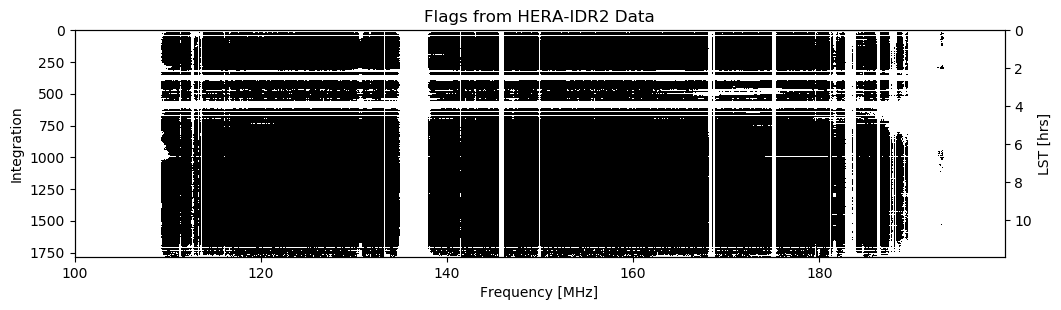

In [9]:
lst_binned_flags_filename = 'idr2.2_flags.LSThrs_0.74-11.40.uvflag'
uvf = UVFlag(str(flag_data_path / lst_binned_flags_filename))

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
cax = plt.imshow(uvf.flag_array[:, 0, :, 0].astype('int'),
                 extent=[uvf.freq_array[0, 0] / 1e6, uvf.freq_array[0, -1] / 1e6, uvf.Ntimes, 0],
                 aspect='auto',
                 cmap='bone')
# fig.colorbar(cax)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Integration')
plt.title('Flags from HERA-IDR2 Data')

ax2 = ax.twinx()
tick_inds = ax.get_yticks()
ax2.set_ylim([0, idr2_lsts_hrs.max()])
ax2.invert_yaxis()
ax2.set_ylabel('LST [hrs]');

**Figure 2** | Flags from LST binned HERA-IDR2.2 data that will be applied to the simulated visibilities from RIMEz.  Flagged and unflagged samples are plotted in white and black, respectively.

## Extract LST Range Subset and Apply Flags

<a id="sec_1.2.2"></a>
The following function reads in the master datasets from RIMEz, defined in the section [Data](#data_paths), extracts the aforementioned LST hour range, and writes them to disk.

In [10]:
def get_datasets(data_path, file_dic, outfile_dir=None,
                 flag_data=True, rfi_files=None,
                 make_data=False, clobber=False,
                 bl_cutoff_length_meters=None, ntimes_to_keep=-1,
                 lst_ranges_rad=None, lst_bin_res=False,
                 sum_key='sum', gsm_key='gsm', gleam_key=None, eor_key='eor'):
    
    # Get metadata for bl and time selects
    # Load empty UVData object for input select
    uvd = UVData()
    uvd.read(os.path.join(data_path, file_dic[list(file_dic.keys())[0]]), read_data=False)
    unique_lsts = np.unique(uvd.lst_array)

    # Filter by baseline length
    if not bl_cutoff_length_meters is None:
        bl_lengths = np.sqrt(np.sum(np.round(uvd.uvw_array[:, :2], decimals=1)**2, axis=1))
        bl_flags = bl_lengths < bl_cutoff_length_meters
    else:
        bl_flags = np.ones(uvd.uvw_array.shape[0]).astype('bool')

    if lst_ranges_rad is None:
        lst_ranges_rad = [[uvd.lst_array.min(), uvd.lst_array.max()]]
    assert len(lst_ranges_rad) == len(rfi_files), \
        "len(lst_ranges_rad) must equal len(rfi_files)"
        
    # Iterate over lst ranges and make / load datasets and apply flags
    for i_lst, lst_range_rad in enumerate(lst_ranges_rad):
        lst_range_hrs = np.array(lst_range_rad) * 12.0 / np.pi
        print('LST Range {:.2f} - {:.2f} hrs:'.format(lst_range_hrs[0], lst_range_hrs[1]))
        print('-' * len('LST Range {:.2f} - {:.2f} hrs:'.format(lst_range_hrs[0], lst_range_hrs[1])),
              end='\n\n')
        outfile_suffix = 'LSThrs_{:.2f}-{:.2f}.uvh5'.format(lst_range_hrs[0],
                                                            lst_range_hrs[1])

        # Filter by times
        lst_inds = np.logical_and(unique_lsts >= lst_range_rad[0],
                                  unique_lsts <= lst_range_rad[-1])
        if np.sum(lst_inds)%2 == 1:
            lst_inds[np.where(lst_inds)[0][-1]] = False
        if ntimes_to_keep > 0 and np.sum(lst_inds) // 2 > ntimes_to_keep:
            nbad_times = np.sum(lst_inds) // 2 - ntimes_to_keep
            lst_inds[np.where(lst_inds)[0][- 2 * nbad_times:]] = False
        
        time_flags = np.logical_and(uvd.lst_array >= unique_lsts[lst_inds][0],
                                    uvd.lst_array <= unique_lsts[lst_inds][-1])

        # Combine bl and time flags
        blt_flags = bl_flags * time_flags
        blt_inds = np.where(blt_flags)[0]

        # Load data components based on blts
        uvd_dic = {}
        for key in file_dic.keys():
            print('Processing {} Data'.format(key))
            print('-' * len('Processing {} data'.format(key)))
            uvd_dic[key] = UVData()
            print('Reading data from {}'.format(file_dic[key]))
            uvd_dic[key].read(file_dic[key], blt_inds=blt_inds)

            if lst_bin_res:
                # Average two time samples in the data together to match LST binned resolution
                uvd_dic[key].downsample_in_time(2.0 * uvd_dic[key].integration_time[0])

            if not outfile_dir is None:
                outfile = os.path.join(outfile_dir, '{}.{}'.format(key, outfile_suffix))
            else:
                outfile = os.path.join(data_path, '{}.{}'.format(key, outfile_suffix))
            if os.path.exists(outfile) and not clobber:
                print('Data already exists at {}'.format(outfile), end='\n\n')
            else:
                print('Writing selected data to {}'.format(outfile), end='\n\n')
                uvd_dic[key].write_uvh5(outfile, clobber=True)

        # Create summed dataset
        print('Creating Summed Data')
        print('-' * len('Creating Summed Data'))
        uvd_dic[sum_key] = copy.deepcopy(uvd_dic[eor_key])
        print('Summing datasets...')
        uvd_dic[sum_key].data_array += uvd_dic[gsm_key].data_array
        if not gleam_key is None:
            uvd_dic[sum_key].data_array += uvd_dic[gleam_key].data_array
            uvd_dic[sum_key].history += '  Sum of {}, {}, and {}.'.format(file_dic[eor_key],
                                                                          file_dic[gsm_key],
                                                                          file_dic[gleam_key])
        else:
            uvd_dic[sum_key].history += '  Sum of {} and {}.'.format(file_dic[eor_key],
                                                                     file_dic[gsm_key])

        if not outfile_dir is None:
            outfile = os.path.join(outfile_dir, '{}.{}'.format(sum_key, outfile_suffix))
        else:
            outfile = os.path.join(data_path, '{}.{}'.format(sum_key, outfile_suffix))
        if os.path.exists(outfile) and not clobber:
            print('Data already exists at {}'.format(outfile), end='\n\n')
        else:
            print('Writing summed dataset to {}'.format(outfile), end='\n\n')
            uvd_dic[sum_key].write_uvh5(outfile, clobber=True)

    
        # Apply flags to data per LST bin
        if flag_data:
            # Apply RFI flags to datasets
            print('Applying flags to datasets')
            print('-' * len('Applying flags to datasets'))
            uvf = UVFlag(rfi_files[i_lst])
            rfi_outfile_suffix = outfile_suffix.replace('uvh5', 'idr2.2_flags.uvh5')

            for key in uvd_dic.keys():
                print('{}: '.format(key)),
                for blpair in uvd_dic[key].get_antpairs():
                    inds, _, pol_inds = uvd_dic[key]._key2inds(blpair)
                    for pol_ind in range(uvd_dic[key].data_array.shape[-1]):
                        uvd_dic[key].flag_array[inds, ..., pol_ind] += uvf.flag_array[..., 0]

                if not outfile_dir is None:
                    outfile = os.path.join(outfile_dir, '{}.{}'.format(key, rfi_outfile_suffix))
                else:
                    outfile = os.path.join(data_path, '{}.{}'.format(key, rfi_outfile_suffix))
                if os.path.exists(outfile) and not clobber:
                    print('Data already exists at {}'.format(outfile), end='\n\n')
                else:
                    print('Writing flagged dataset to {}'.format(outfile), end='\n\n')
                    uvd_dic[key].write_uvh5(outfile, clobber=True)

In [11]:
sum_key = 'sum'
gsm_key = 'egsm'
gleam_key = 'gleam'
eor_key = 'eor'

data_path = "/lustre/aoc/projects/hera/Validation/"
eor_filename = "hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5"
egsm_filename = "hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5"
gleam_filename = "hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/"\
                 "hera_hex37_full_gleam_plus_brights_v01.uvh5"
outfile_dir = "/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/"

file_dic = {}
file_dic[eor_key] = os.path.join(data_path, eor_filename)
file_dic[gsm_key] = os.path.join(data_path, egsm_filename)
file_dic[gleam_key] = os.path.join(data_path, gleam_filename)

# ntimes_to_keep = 594
ntimes_to_keep = 1782
lst_ranges_rad = [[0.19497920507075228, 2.984199801303763]]
bl_cutoff_length_meters = 30.0 # meters
make_data =  False
flag_data = True
clobber = False

rfi_files = [str(flag_data_path / lst_binned_flags_filename)]

get_datasets(data_path, file_dic, outfile_dir=outfile_dir,
             make_data=make_data, clobber=clobber,
             flag_data=True, rfi_files=rfi_files,
             ntimes_to_keep=ntimes_to_keep,
             bl_cutoff_length_meters=bl_cutoff_length_meters,
             lst_ranges_rad=lst_ranges_rad, lst_bin_res=True,
             sum_key=sum_key, gsm_key=gsm_key, gleam_key=gleam_key)

Telescope RIMEz calculation is not in known_telescopes.


LST Range 0.74 - 11.40 hrs:
---------------------------

Processing eor Data
-------------------
Reading data from /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5


The time difference between integrations is not the same as the integration time for baseline (9, 9). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 6). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 3). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 22). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (24, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (24, 21). The output may average across longer time interval

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/eor.LSThrs_0.74-11.40.uvh5

Processing egsm Data
--------------------
Reading data from /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5


Telescope RIMEz calculation is not in known_telescopes.
The time difference between integrations is not the same as the integration time for baseline (9, 9). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 6). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 3). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 22). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (24, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (24,

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/egsm.LSThrs_0.74-11.40.uvh5

Processing gleam Data
---------------------
Reading data from /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5


Telescope RIMEz calculation is not in known_telescopes.
The time difference between integrations is not the same as the integration time for baseline (9, 9). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 6). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 3). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 22). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (24, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (24,

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/gleam.LSThrs_0.74-11.40.uvh5

Creating Summed Data
--------------------
Summing datasets...
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/sum.LSThrs_0.74-11.40.uvh5

Applying flags to datasets
--------------------------
eor: 
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/eor.LSThrs_0.74-11.40.idr2.2_flags.uvh5

egsm: 
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/egsm.LSThrs_0.74-11.40.idr2.2_flags.uvh5

gleam: 
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/gleam.LSThrs_0.74-11.40.idr2.2_flags.uvh5

sum: 
Data already exists at /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/sum.LSThrs_0.74-11.40.idr2.2_flags.uvh5



## Load Datasets

In [12]:
def load_datasets(file_dic, params, inpaint=False, delay_transform=False):
    bls = params['bls']
    polarizations = params['polarizations']
    
    # Read in datasets
    data_dic = {}
    
    # EoR
    data_dic['E'] = hc.delay_filter.DelayFilter(file_dic['eor'])
    data_dic['E'].read(bls=bls, polarizations=polarizations)


    # Foregrounds
    # GSM
    data_dic['F_gsm'] = hc.delay_filter.DelayFilter(file_dic['gsm'])
    data_dic['F_gsm'].read(bls=bls, polarizations=polarizations)
    # GLEAM
    data_dic['F_gleam'] = hc.delay_filter.DelayFilter(file_dic['gleam'])
    data_dic['F_gleam'].read(bls=bls, polarizations=polarizations)
    # Combined foregrounds
    data_dic['F'] = copy.deepcopy(data_dic['F_gsm'])
    data_dic['F'].data += data_dic['F_gleam'].data

    # Sum EoR + Foregrounds
    data_dic['S'] = hc.delay_filter.DelayFilter(file_dic['sum'])
    data_dic['S'].read(bls=bls, polarizations=polarizations)

    metadata_dic = {}
    metadata_dic['lsts_hrs'] = data_dic['S'].lsts * 12 / np.pi
    metadata_dic['freqs'] = data_dic['S'].freqs
    metadata_dic['flags'] = UVFlag(file_dic['flags'])
    
    return data_dic, metadata_dic

### Raw Datasets

In [13]:
data_path = "/lustre/aoc/projects/hera/Validation/test-3.1.0/"
eor_filename = "datasets/eor.LSThrs_0.74-11.40.uvh5"
gsm_filename = "datasets/egsm.LSThrs_0.74-11.40.uvh5"
gleam_filename = "datasets/gleam.LSThrs_0.74-11.40.uvh5"
sum_filename = "datasets/sum.LSThrs_0.74-11.40.uvh5"

# Flags are stored in a UVFlag dataset
lst_binned_flags_filename = "flags/idr2.2_flags.LSThrs_0.74-11.40.uvflag"

file_dic = {}
file_dic['eor'] = os.path.join(data_path, eor_filename)
file_dic['gsm'] = os.path.join(data_path, gsm_filename)
file_dic['gleam'] = os.path.join(data_path, gleam_filename)
file_dic['sum'] = os.path.join(data_path, sum_filename)
file_dic['flags'] = os.path.join(data_path, lst_binned_flags_filename)

params = {}
params['bls'] = [(13, 6), (34, 21), (24, 21), (35, 28), (23, 22)]
params['polarizations'] = ['xx']
params['spws'] = [(150, 350), (400, 600), (490, 690), (515, 695), (600, 800)]
params['lst_cuts'] = [(1., 2.7), (4.0, 6.5), (8.5, 11)]
params['min_dly'] = 2000.0
params['skip_wgt'] = 0.2
params['edgecut_low'] = 150
params['edgecut_hi'] = 150

In [14]:
data_dic, metadata_dic = load_datasets(file_dic, params)

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


In [15]:
def waterfall_column(waterfalls, flags, titles, clims=None, clabels=None, cmaps=None, ylims=None, 
                     ylabel='JD - 2458098', extents=None, hspace=.1, figsize=(12,6), dpi=100, fignum=None):
    '''Useful plotting function for the IDR 2.2 memo.'''
    if clims is None:
        clims = [None for i in range(len(waterfalls))]
    if clabels is None:
        clabels = [None for i in range(len(waterfalls))]
    if cmaps is None:
        cmaps = [None for i in range(len(waterfalls))]
    if ylims is None:
        ylims = [None for i in range(len(waterfalls))]
    if not any(isinstance(ex, list) for ex in extents):
        extents = [extents for i in range(len(waterfalls))]
    if fignum is None:
        fig, axes = plt.subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi)
    else:
        fig, axes = plt.subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi, num=fignum)
    plt.subplots_adjust(hspace=hspace)
    for ax, wf, f, t, clim, clabel, cmap, ylim, ex in zip(axes, waterfalls, flags, titles,
                                                          clims, clabels, cmaps, ylims, extents):
        with np.errstate(divide='ignore', invalid='ignore'):
            im = ax.imshow(wf / ~f, aspect='auto', extent=ex, cmap=cmap)
        fig.colorbar(im, ax=ax, label=clabel, aspect=8, pad=.025)
        if ax == axes[-1]:
            ax.set_xlabel('Frequency (MHz)')    
        im.set_clim(clim)
        ax.set_ylabel(ylabel)
        ax.set_ylim(ylim)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.02, 0.9, t, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

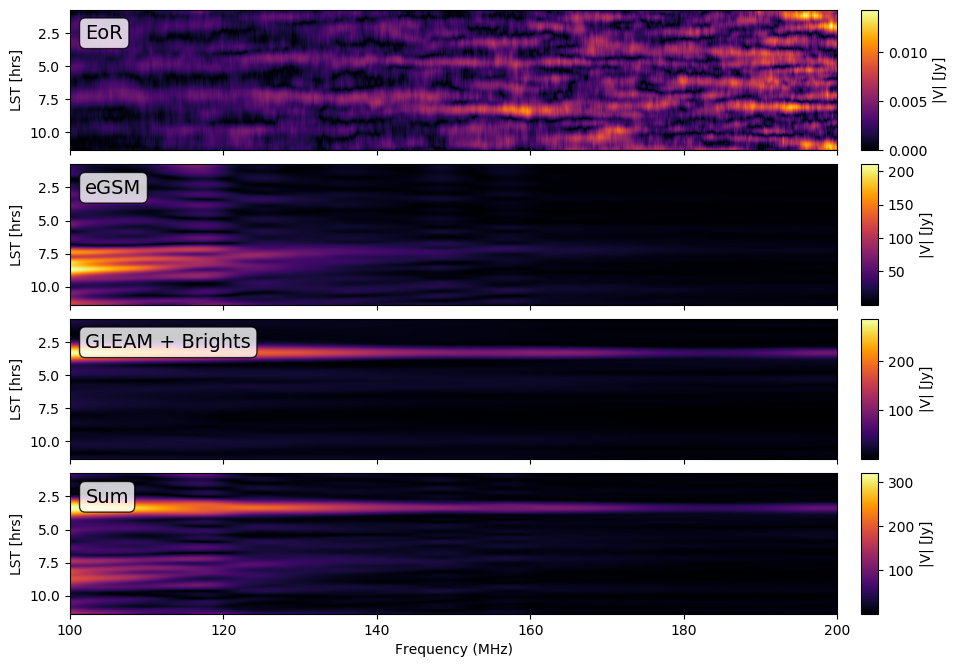

In [16]:
bl_key = (13, 6, 'ee')

waterfalls = [np.abs(data_dic['E'].data[bl_key]), np.abs(data_dic['F_gsm'].data[bl_key]),
              np.abs(data_dic['F_gleam'].data[bl_key]), np.abs(data_dic['S'].data[bl_key])]
flags = [np.zeros_like(data_dic['S'].flags[bl_key])] * len(waterfalls)
titles = ['EoR', 'eGSM', 'GLEAM + Brights', 'Sum']
clabels = ['|V| [Jy]'] * len(waterfalls)
cmaps = ['inferno'] * len(waterfalls)
ylabel = 'LST [hrs]'
extents = [[metadata_dic['freqs'][0] / 1e6, metadata_dic['freqs'][-1] / 1e6,
            metadata_dic['lsts_hrs'].max(), metadata_dic['lsts_hrs'].min()]] * len(waterfalls)

waterfall_column(waterfalls, flags, titles, clabels=clabels, cmaps=cmaps,
                 ylabel=ylabel, extents=extents, figsize=(12, 8))

**Figure 3** | Absolute value of the simulated visibilities from RIMEz for the components used in this work, i.e. EoR, eGSM, and Gleam + Brights.  The sum of EoR + eGSM + (GLEAM + Brights) can be seen in the bottom plot.  This summed dataset will be the main dataset for this work while the other components will be used for reference.


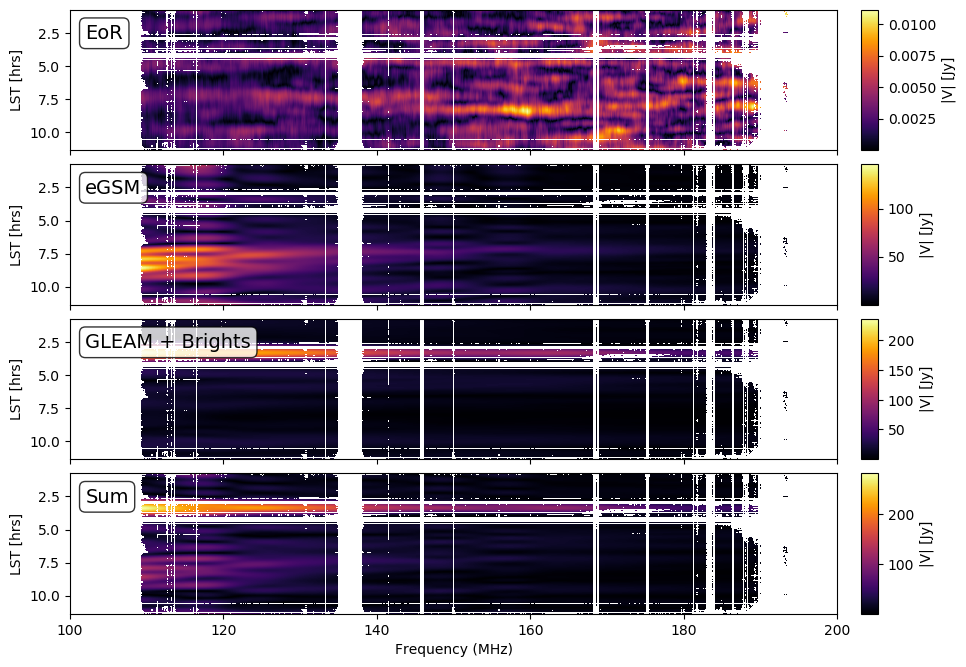

In [17]:
bl_key = (13, 6, 'ee')

waterfalls = [np.abs(data_dic['E'].data[bl_key]), np.abs(data_dic['F_gsm'].data[bl_key]),
              np.abs(data_dic['F_gleam'].data[bl_key]), np.abs(data_dic['S'].data[bl_key])]
flags = [uvf.flag_array[:, 0, :, 0]] * len(waterfalls)
titles = ['EoR', 'eGSM', 'GLEAM + Brights', 'Sum']
clabels = ['|V| [Jy]'] * len(waterfalls)
cmaps = ['inferno'] * len(waterfalls)
ylabel = 'LST [hrs]'
extents = [[metadata_dic['freqs'][0] / 1e6, metadata_dic['freqs'][-1] / 1e6,
            metadata_dic['lsts_hrs'].max(), metadata_dic['lsts_hrs'].min()]] * len(waterfalls)

waterfall_column(waterfalls, flags, titles, clabels=clabels, cmaps=cmaps,
                 ylabel=ylabel, extents=extents, figsize=(12, 8))

**Figure 4** | Absolute value of the same simulated visibilities from Figure 3 but with flags applied from LST binned HERA-IDR2.2 data.

During in-painting, the `edgecut_low` and `edgecut_hi` variables set the number of channels at the low and high end of the frequency range that are unused.  The edges of the band are typically flagged entirely and as such are unreliable for performing in-painting, as can be seen above in Figure 4.  A plot showing what regions of the band are ignored during in-painting can be seen below in Figure 5.

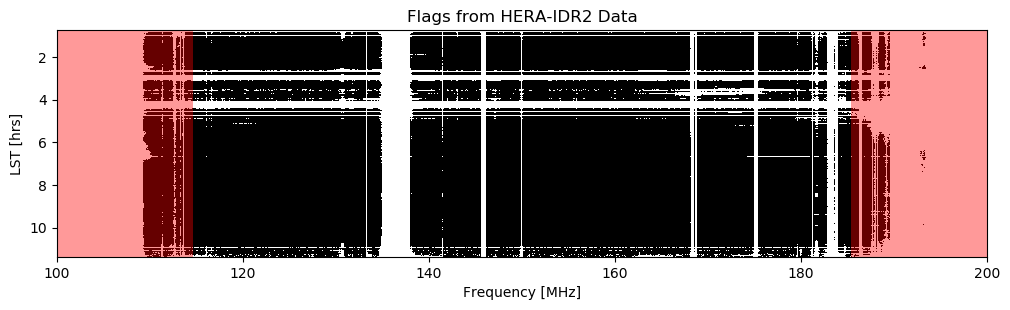

In [18]:
fig = plt.figure(figsize=(12, 3), dpi=100)
ax = plt.gca()
cax = plt.imshow(metadata_dic['flags'].flag_array[:, 0, :, 0].astype('int'),
                 extent=[metadata_dic['freqs'][0] / 1e6, metadata_dic['freqs'][-1] / 1e6,
                         metadata_dic['lsts_hrs'].max(), metadata_dic['lsts_hrs'].min()],
                 aspect='auto', cmap='bone')
# add rectangles to show what fraction of the band are used for in-painting
rect_low  = Rectangle((metadata_dic['freqs'][0] / 1e6, metadata_dic['lsts_hrs'].min()),
                      (metadata_dic['freqs'][params['edgecut_low']] - metadata_dic['freqs'][0]) / 1e6,
                      (metadata_dic['lsts_hrs'].max() - metadata_dic['lsts_hrs'].min()),
                      linewidth=0.5, facecolor='r', alpha=0.4)
rect_hi  = Rectangle((metadata_dic['freqs'][-params['edgecut_hi']] / 1e6, metadata_dic['lsts_hrs'].min()),
                     (metadata_dic['freqs'][-1] - metadata_dic['freqs'][-params['edgecut_hi']]) / 1e6,
                     (metadata_dic['lsts_hrs'].max() - metadata_dic['lsts_hrs'].min()),
                     linewidth=0.5, facecolor='r', alpha=0.4)
ax.add_patch(rect_low)
ax.add_patch(rect_hi)

plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [hrs]')
plt.title('Flags from HERA-IDR2 Data');

**Figure 5** | Flags from LST binned HERA-IDR2.2 data with the edgecuts highlighted in red.  Flagged and unflagged samples are plotted in white and black, respectively.  The red regions are not used during the delay in-painting process.

### Load In-painted Data

The flagged datasets were in-painted using the analysis scripts inside of the `H1C_IDR2` GitHub repository.  The two files of interest used to perform the in-painting are:

  - `preprocess_params.yaml`: file containing the in-painting parameters
  - `preprocess_data.py`: code that performe the in-painting via a 1D frequency CLEAN

In [19]:
data_path = "/lustre/aoc/projects/hera/Validation/test-3.1.0/"
eor_filename = "datasets/preprocessed/v2/eor.LSThrs_0.74-11.40.idr2.2_flagsP.uvh5"
gsm_filename = "datasets/preprocessed/v2/egsm.LSThrs_0.74-11.40.idr2.2_flagsP.uvh5"
gleam_filename = "datasets/preprocessed/v2/gleam.LSThrs_0.74-11.40.idr2.2_flagsP.uvh5"
sum_filename = "datasets/preprocessed/v2/sum.LSThrs_0.74-11.40.idr2.2_flagsP.uvh5"
lst_binned_flags_filename = "flags/idr2.2_flags.LSThrs_0.74-11.40.uvflag"

inp_file_dic = {}
inp_file_dic['eor'] = sorted(glob.glob(os.path.join(data_path, eor_filename)))
inp_file_dic['gsm'] = sorted(glob.glob(os.path.join(data_path, gsm_filename)))
inp_file_dic['gleam'] = sorted(glob.glob(os.path.join(data_path, gleam_filename)))
inp_file_dic['sum'] = sorted(glob.glob(os.path.join(data_path, sum_filename)))
inp_file_dic['flags'] = sorted(glob.glob(os.path.join(data_path, lst_binned_flags_filename)))

In [20]:
inp_data_dic, inp_metadata_dic = load_datasets(inp_file_dic, params)

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


The parameters used to perform the in-painting were adapted from those currently being used by the `H1C_IDR2`
analysis team available on lustre via
```
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/preprocess_params.yaml
```

The modified parameter values used to perform the in-painting here are printed below.

In [21]:
temp = UVData()
temp.read(inp_file_dic['eor'], read_data=False)
print(temp.history)

Telescope RIMEz calculation is not in known_telescopes.


time series generated from /lustre/aoc/projects/hera/zmartino/hera_validation/test-0.1/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.rimezh5  Read/written with pyuvdata version: 1.4.2.  Git origin: https://github.com/RadioAstronomySoftwareGroup/pyuvdata.git.  Git hash: 6eaa2d32d7656adad3021d221712f47745efce46.  Git branch: master.  Git description: v1.4-316-g6eaa2d32.  Downselected to specific baseline-times using pyuvdata. Downsampled data to 21.460000 second integration time using pyuvdata.  Read/written with pyuvdata version: 2.1.3.dev12+gcb87678.  Downselected to specific baselines, polarizations using pyuvdata.  Downselected to specific frequencies using pyuvdata.

Ran preprocess_data.py fg filt step at
UTC 2020-10-24 02:49:21.938738 with 
hera_pspec [105ddb69b9], hera_cal [],
hera_qm [] and pyuvdata [2.1.3.dev12+gcb87678]
on data_template /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/*.LSThrs_0.74-11.40.idr2.2_flags.uvh5
with fg filt algorithm par

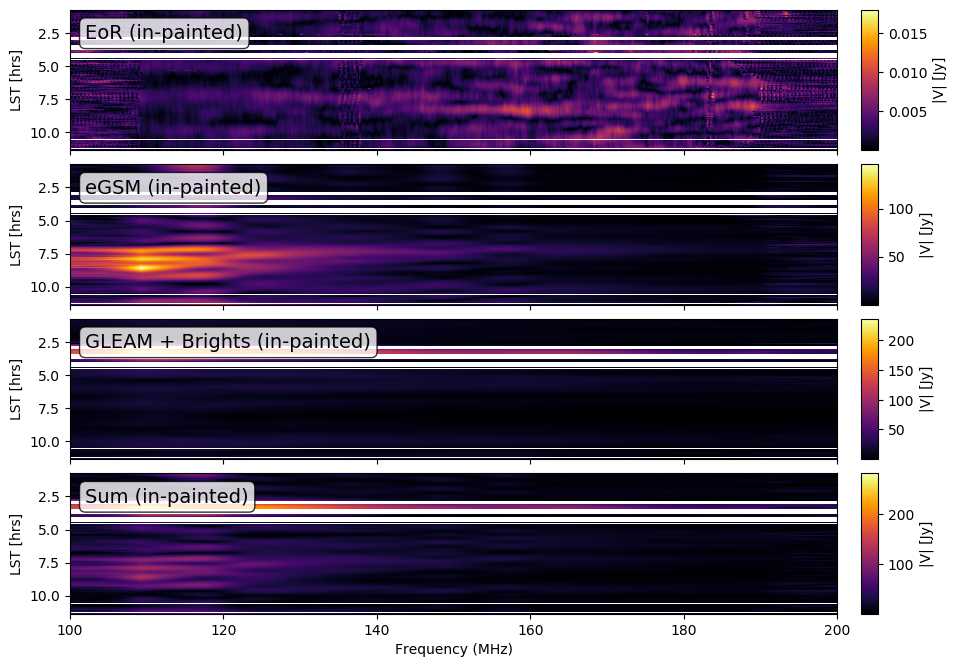

In [22]:
bl_key = (13, 6, 'ee')

waterfalls = [np.abs(inp_data_dic['E'].data[bl_key]), np.abs(inp_data_dic['F_gsm'].data[bl_key]),
              np.abs(inp_data_dic['F_gleam'].data[bl_key]), np.abs(inp_data_dic['S'].data[bl_key])]
flags = [inp_data_dic['E'].flags[bl_key], inp_data_dic['F_gsm'].flags[bl_key],
         inp_data_dic['F_gleam'].flags[bl_key], inp_data_dic['S'].flags[bl_key]]
titles = ['EoR (in-painted)', 'eGSM (in-painted)', 'GLEAM + Brights (in-painted)', 'Sum (in-painted)']
clabels = ['|V| [Jy]'] * len(waterfalls)
cmaps = ['inferno'] * len(waterfalls)
ylabel = 'LST [hrs]'
extents = [[metadata_dic['freqs'][0] / 1e6, metadata_dic['freqs'][-1] / 1e6,
            metadata_dic['lsts_hrs'].max(), metadata_dic['lsts_hrs'].min()]] * len(waterfalls)

waterfall_column(waterfalls, flags, titles, clabels=clabels, cmaps=cmaps,
                 ylabel=ylabel, extents=extents, figsize=(12, 8))

**Figure 6** | Absolute value of the visibilities from the various simulation components _after_ applying flags and performing the in-painting using the aformentioned files in the `HERA-Team/H1C_IDR2` repository.

## Spectral Windows

As mentioned above, recovery of the true power spectrum, obtained from the summed dataset without flags, via in-painting is highly dependent on the distribution of flags within a given spectral window (spw).  The spws used here were chosen to highlight this importance via a variety of different flagging patterns.  The selected spws used in this analysis are overlaid on the flags in Figure 7.

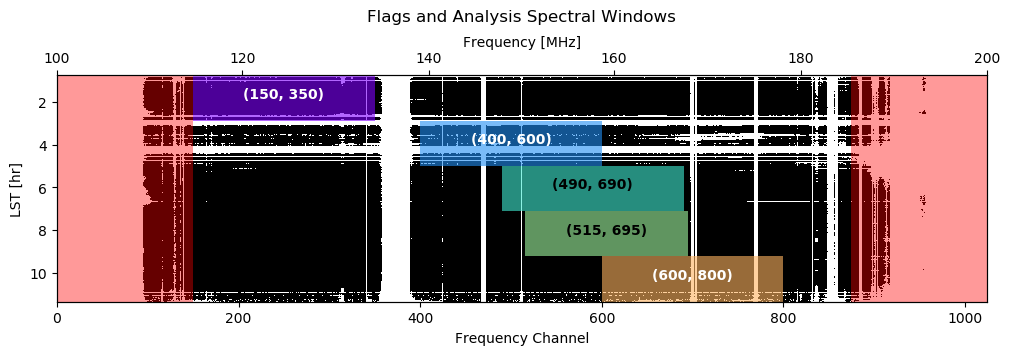

In [23]:
fig = plt.figure(figsize=(12, 3), dpi=100)
ax = plt.gca()
cax = plt.imshow(metadata_dic['flags'].flag_array[:, 0, :, 0].astype('int'),
                 extent=[0, metadata_dic['flags'].Nfreqs,
                         metadata_dic['lsts_hrs'].max(), metadata_dic['lsts_hrs'].min()],
                 aspect='auto', cmap='bone')
# add rectangles to show what fraction of the band are used for in-painting
rect_low  = Rectangle((0, metadata_dic['lsts_hrs'].min()),
                      params['edgecut_low'],
                      metadata_dic['lsts_hrs'].max() - metadata_dic['lsts_hrs'].min(),
                      linewidth=0.5, facecolor='r', alpha=0.4)
rect_hi  = Rectangle((metadata_dic['flags'].Nfreqs - params['edgecut_hi'],
                      metadata_dic['lsts_hrs'].min()),
                     params['edgecut_hi'],
                     metadata_dic['lsts_hrs'].max() - metadata_dic['lsts_hrs'].min(),
                     linewidth=0.5, facecolor='r', alpha=0.4)
ax.add_patch(rect_low)
ax.add_patch(rect_hi)

ax.set_xlabel('Frequency Channel')
ax.set_ylabel('LST [hr]')
ax.set_title('Flags and Analysis Spectral Windows', pad=10)

ax_freq = ax.twiny()
tick_inds = np.linspace(0, metadata_dic['flags'].Nfreqs - 1, 6).astype('int')
ax_freq.set_xticks(tick_inds)
ax_freq.set_xticklabels(['{:.0f}'.format(x/1e6) for x in metadata_dic['freqs'][tick_inds]])
ax_freq.set_xlabel('Frequency [MHz]')

nspws = len(params['spws'])
heights = [(metadata_dic['lsts_hrs'].max() - metadata_dic['lsts_hrs'].min()) / nspws] * nspws
colors = plt.cm.rainbow(np.linspace(0.0, 0.75, nspws))
label_colors = ['w', 'w', 'k', 'k', 'w']
for i_spw, spw in enumerate(params['spws']):
    width = spw[1] - spw[0]
    ax.add_patch(Rectangle((spw[0], i_spw * heights[i_spw] + metadata_dic['lsts_hrs'].min()),
                           width, heights[i_spw],
                           facecolor=colors[i_spw], alpha=0.6))
    ax.annotate('{}'.format(spw), (spw[0] + width/2,
                                   (i_spw + 0.5) * heights[i_spw] + metadata_dic['lsts_hrs'].min()),
                color=label_colors[i_spw], horizontalalignment='center', fontweight='bold')

**Figure 7** | Flags applied from LST binned HERA-IDR2.2 data overlaid with the edgecuts highlighted in red.  Highlighted in purple, blue, blue-green, green, and orange are five different spectral window ranges with the range in frequency channel number overplotted in black or white.  The fourth spw, (515, 695), was chosen to match exactly the spw used in the IDR2.2 analysis.  To clarify, the blocks represent what range of frequencies is used in the analysis per spw.  All times within a given spw are used, not those restricted to the rectangles plotted above.

# $\texttt{hera_pspec}$ Analysis

<a id="hera_pspec"></a>
The in-painted data were passed through $\texttt{hera_pspec}$ to generate cosmological power spectra in units of $\rm{mK}^2 \, h^{-3} \, \rm{Mpc}^3$.  The upcoming HERA IDR2.2 upper limits paper will be using data in the range of ~1 - 11 hours of LST and a spw of (515, 695) (frequency channel indices).  To mimic this result, an analysis using $\texttt{hera_pspec}$ of the full LST range of 0.7 - 11.4 hours of LST used above is performed.  Because the following plots mimic, excluding some steps like additional time and baseline averaging, the actual H1C IDR2 analysis pipeline, they serve as the final evidence for a success or failure of this validation test.

##  $\texttt{hera_pspec}$ Functions

Some useful functions for interfacing with $\texttt{hera_pspec}$ and its data products are defined below.

In [24]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies
flag_nchan_low, flag_nchan_high = (params['edgecut_low'],
                                   params['edgecut_hi'])
freq_slice = slice(flag_nchan_low, -flag_nchan_high)

# load beam-dependent normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()][freq_slice]
    Omegapp = h5f['Omegapp'][()][freq_slice]

Omega = {'xx': Omega, 'yy': Omega}
Omegapp = {'xx': Omegapp, 'yy': Omegapp}
# Omega = {'ee': Omega, 'nn': Omega}
# Omegapp = {'ee': Omegapp, 'nn': Omegapp}
    
beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp,
                                               np.unique(metadata_dic['freqs'][freq_slice]),
                                               cosmo=cosmo)

def calc_pspec(vis_file, outfile, spw_ranges=None, bls=None, polarizations=None, overwrite=True):
    uvd = UVData()
    uvd.read(vis_file, bls=bls, polarizations=polarizations)
    if not bls is None:
        blpairs = [(bl, bl) for bl in bls]
    else:
        blpairs = None
    if not polarizations is None:
        pol_pairs = [('xx', 'xx')]
        # pol_pairs = [('ee', 'ee')]
    else:
        pol_pairs = [(pol, pol) for pol in polarizations]
    _ = hera_pspec.pspecdata.pspec_run([uvd, uvd], outfile, file_type="uvh5",
                                       taper="blackman-harris", beam=beam,
                                       cosmo=cosmo, spw_ranges=spw_ranges,
                                       blpairs=blpairs, pol_pairs=pol_pairs,
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=overwrite, verbose=False)
    del(uvd)

In [25]:
def plot_time_averaged_delay_spectra(uvp_dic, metadata_dic, params,
                                     bl=None, fontsize=14, max_delay_ns=None):
    
    freqs = metadata_dic['freqs']
    spws = params['spws']
    nspws = len(spws)

    if not bl is None:
        bl_key = bl + ('xx',)
        # bl_key = bl + ('ee',)
    else:
        bl_key = params['bls'][0] + ('xx',)
        # bl_key = params['bls'][0] + ('ee',)

    label_dic = {
        'eor' : 'EoR',
        'gsm' : 'eGSM',
        'gleam' : 'GLEAM',
        'sum' : 'Sum'
        }
    keys = ['eor', 'gsm', 'gleam', 'sum']

    # Time average power spectra
    uvp_avg_dic = copy.deepcopy(uvp_dic)
    for key in keys:
        uvp_avg_dic[key].average_spectra(time_avg=True)

    fig = plt.figure(figsize=(13.5, 2.5 * nspws))
    gs = GridSpec(nspws, 1)

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_spw in range(nspws):
            spw = spws[i_spw]

            # Get delays and kparas
            delays = uvp_avg_dic[key].get_dlys(i_spw) * 1.0e9
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            kparas = delays * 1.0e-09 * tau_to_kpara

            if max_delay_ns is not None:
                delay_xlim = [delays[delays.size//2 - 1], max_delay_ns]
            else:
                delay_xlim = [delays[delays.size//2 - 1], delays[-1]]

            # Plot delay power spectrum for spw
            ax = fig.add_subplot(gs[i_spw, 0])
            ps_key = (i_spw, (bl, bl), 'xx')
            # ps_key = (i_spw, (bl, bl), 'ee')
            for key in keys:
                if i_spw == 0:
                    ax.plot(delays, uvp_avg_dic[key].get_data(ps_key)[0].real, lw=2, label=label_dic[key])
                else:
                    ax.plot(delays, uvp_avg_dic[key].get_data(ps_key)[0].real, lw=2)            

            ax.set_xlim(delay_xlim)
            ax.set_yscale('log')
            ax.set_ylabel(r'$P(k)$ [mK$^2$ Mpc$^3$]', fontsize=fontsize)
            ax.tick_params(axis='both', which='both', labelsize=fontsize)
            ax.grid(axis='both', which='both', alpha=0.1, color='k')

            # Twin axis for plotting kparallels
            ax2 = plt.twiny(ax)
            ax2.set_xlim([kparas[kparas.size//2 - 1], kparas[-1]])
            ax2.tick_params(which='both', labelsize=14)
            if i_spw  == 0:
                ax2.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]', fontsize=14)
            if i_spw == nspws - 1:
                ax.set_xlabel(r'$\tau$ [ns]', fontsize=14)


            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.012, 0.05, 'spw = {}'.format(spws[i_spw]), transform=ax.transAxes,
                    fontsize=14, verticalalignment='bottom', horizontalalignment='left', bbox=props)

        fig.tight_layout()
        gs.update(top=0.9)
        fig.legend(loc='upper center', ncol=len(keys), fontsize=fontsize, frameon=False)

In [26]:
def plot_pspec_waterfalls(bl, uvp_dic, params, metadata_dic, use_clean_flags=True, inp_data_dic=None):
    freqs = metadata_dic['freqs']
    lsts_hrs = metadata_dic['lsts_hrs']
    spws = params['spws']
    nspws = len(spws)
    ntimes = lsts_hrs.size

    label_dic = {'eor' : 'EoR',
                 'sum' : 'Sum',
                 'recovered' : 'In-Painted'}
    
    nrows = nspws
    ncols = 4
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4 * nrows))
    axs = np.array(axs)

    flag_array = metadata_dic['flags'].flag_array[:, 0, :, 0]
    if use_clean_flags:
        avg_flags = np.logical_not(np.all(inp_data_dic['E'].flags[params['bls'][0] + ('ee',)], axis=1))
    else:
        avg_flags = np.logical_not(np.all(flag_array, axis=1))

    for ax in axs[:, 0]:
        ax.set_ylabel('LST [hrs]')

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_spw, spw in enumerate(params['spws']):
            # Get delays and kparas
            delays = uvp_dic['sum'].get_dlys(i_spw) * 1.0e9
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            kparas = delays * 1.0e-09 * tau_to_kpara
            
            delays_xlim = [delays[delays.size//2], delays[-1]]
            tick_inds = np.linspace(delays.size//2, delays.size - 1, 3).astype('int')
            extent = [delays.min(), delays.max(),
                      lsts_hrs.max(), lsts_hrs.min()]

            # Plot flags for spw
            ax = axs[i_spw, 0]
            cax = ax.imshow(flag_array[:, spw[0]:spw[1]].astype('int'),
                            cmap='bone', aspect='auto', extent=[spw[0], spw[1], lsts_hrs.max(), lsts_hrs.min()])
            ax.hlines(lsts_hrs[~avg_flags], spw[0], spw[1], linestyle='-', alpha=0.1, color='r')
            ax.set_xticks([])
            if i_spw == 0: ax.set_title('Flags')
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.05, 0.95, 'spw = {}'.format(spw), transform=ax.transAxes,
                    fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

            # Key for accessing ps in uvpspec object
            ps_key = (i_spw, (bl, bl), 'xx')
            
            # Plot ps
            for i_key, key in enumerate(['eor', 'sum', 'recovered']):
                ax = axs[i_spw, i_key + 1]
                
                if key == 'recovered':
                    cax = ax.imshow(np.log10(uvp_dic[key].get_data(ps_key).real),
                                extent=extent, aspect='auto', vmin=clim[0], vmax=clim[1])
                    # Plot flagged integrations on top of imshow
                    ax.hlines(lsts_hrs[~avg_flags], *delays_xlim,
                              linestyle='-', alpha=0.1, color='r')
                else:
                    cax = ax.imshow(np.log10(uvp_dic[key].get_data(ps_key).real),
                                    extent=extent, aspect='auto')
                    if key == 'sum':
                        clim = cax.get_clim()
                
                fig.colorbar(cax, ax=ax, label=r'$|P(k)|$ [mK$^2$ Mpc$^3$]')
                if i_spw == 0: ax.set_title(label_dic[key])
                ax.set_xlim(delays_xlim)

            for ax in axs[i_spw, 1:]:
                if i_spw == nspws - 1: ax.set_xlabel(r'$\tau$ [ns]')

                # Twin axis for plotting kparallels
                ax2 = plt.twiny(ax)
                ax2.set_xlim([kparas[kparas.size//2], kparas[-1]])
                if i_spw == 0: ax2.set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')

    fig.tight_layout()

In [27]:
def plot_time_averaged_pspec_spectra_with_flags_and_residuals(uvp_dic, params,
                                                              metadata_dic, inp_data_dic,
                                                              bl=None, bl_dic=None,
                                                              max_flag_occupancy=None,
                                                              plot_frac_diff=False, plot_all_blps=False,
                                                              max_delay_ns=None, ylims=None, clim=None,
                                                              symlog=False, linthresh=0.01, linscale=0.01,
                                                              text_loc=(0.05, 0.9), fontsize=14):
    S = data_dic['S']
    S_inp = inp_data_dic['S']
    uvf = metadata_dic['flags']
    lsts_hrs = metadata_dic['lsts_hrs']
    freqs = metadata_dic['freqs']
    spws = params['spws']
    ntimes = lsts_hrs.size
    nspws = len(spws)
    flag_array = uvf.flag_array[:, 0, :, 0]
    
    if not bl is None:
        bl_key = bl + ('ee',)
    else:
        bl_key = params['bls'][0] + ('ee',)
    
    if not ylims is None and len(ylims) == 1 and nspws > 1:
        ylims = [ylims[0] for _ in range(nspws)]

    fig = plt.figure(figsize=(13.5, 3 * nspws))
    gs = GridSpec(nspws, 4)

    fontsize = 14
    label_dic = {'eor' : 'EoR',
                 'sum' : 'True',
                 'recovered' : 'In-Painted'}
    linestyle_dic = {'eor' : ':',
                     'sum' : '--',
                     'recovered' : '-'}
    
    # Setup boolean array for LST cuts
    lst_cut_ints = np.zeros(lsts_hrs.size).astype('bool')
    for lst_range in params['lst_cuts']:
        lst_inds = np.logical_and(lsts_hrs >= lst_range[0],
                                  lsts_hrs <= lst_range[1])
        lst_cut_ints += lst_inds
    # Invert to flag the LSTs we don't want
    lst_cut_ints = ~lst_cut_ints

    uvp_avg = {}
    # Set up stats array
    for key in uvp_dic.keys():
        # Extract uvpspec object from uvps dic
        uvp_avg[key] = copy.deepcopy(uvp_dic[key])

        for i_spw, spw in enumerate(spws):
            ps_key = (i_spw, (params['bls'][0], params['bls'][0]), 'xx')
            
            # Need to pull the integrations where the flagging criterion is not met
            # i.e. bad_ints = 1.0 for integrations we do NOT want to use
            if not max_flag_occupancy is None:
                flags_spw = flag_array[:, spw[0]:spw[1]]
                bad_ints = np.sum(flags_spw, axis=1) > max_flag_occupancy * (spw[1] - spw[0])
                bad_ints += ~uvp_dic['recovered'].get_integrations(ps_key).astype('bool')
            else:
                bad_ints = ~uvp_dic['recovered'].get_integrations(ps_key).astype('bool')

            # Combine with the LST cuts
            bad_ints += lst_cut_ints
                
            # Reshape into (ntimes, ndlys)
            bad_ints = np.repeat(bad_ints[:, np.newaxis], spw[1] - spw[0], axis=1)
                
            # Set stats array for each bl pair in uvp
            for blp in uvp_avg[key].get_blpairs():
                uvp_avg[key].set_stats('bad_ints', (i_spw, blp, 'xx'), bad_ints)
                
        # Average delay spectra over time using bad_ints as weights
        uvp_avg[key].average_spectra(time_avg=True, error_weights='bad_ints')

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_spw, spw in enumerate(spws):
            
            # Plot flags for spw
            ax = fig.add_subplot(gs[i_spw, 0])
            cax = ax.imshow(flag_array[:, spw[0]:spw[1]].astype('int'),
                            cmap='bone', aspect='auto', extent=[spw[0], spw[1], ntimes, 0])
            ax.hlines(np.arange(ntimes)[bad_ints[:, 0]], spw[0], spw[1], linestyle='-', alpha=0.1, color='r')
            ax.set_xticks([])
            ax.set_yticks([])
            if i_spw == 0: ax.set_title('Flags')
            
            # Get delays and kparas
            delays = uvp_avg[key].get_dlys(i_spw) * 1.0e9
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            kparas = delays * 1.0e-09 * tau_to_kpara
            
            # Plot delay power spectrum for spw
            ax = fig.add_subplot(gs[i_spw, 1:-1])

            if max_delay_ns is None:
                delays_xlim = [delays[delays.size//2], delays[-1]]
                tick_inds = np.linspace(delays.size//2, delays.size - 1, 6).astype('int')
            else:
                delays_xlim = [delays[delays.size//2], max_delay_ns]
                max_delay_ind = np.argmin(np.abs(delays - max_delay_ns))
                tick_inds = np.linspace(delays.size//2, max_delay_ind, 6).astype('int')
            
            ps_key = (i_spw, (bl, bl), 'xx')
            
            if plot_frac_diff:
                if plot_all_blps:
                    blps = uvp_avg['sum'].get_blpairs()
                else:
                    blps = [(bl, bl)]
                    
                for blp in blps:
                    recovered_ps = uvp_avg['recovered'].get_data((i_spw, blp, 'xx'))[0].real
                    true_ps = uvp_avg['sum'].get_data((i_spw, blp, 'xx'))[0].real

                    frac_diff = (recovered_ps - true_ps) / true_ps
                    
                    if plot_all_blps:
                        if i_spw == 0:
                            ax.plot(delays, frac_diff, label=bl_dic[blp[0]])
                        else:
                            ax.plot(delays, frac_diff)
                    else:
                        ax.plot(delays, frac_diff, c=colors[i_spw], lw=2, label='True')
                ax.hlines(0.0, *delays_xlim, color='k', linestyle='-')
                ax.set_ylabel(r'Fractional Error', fontsize=fontsize)
                if not plot_all_blps:
                    ax.legend(loc='upper right', ncol=len(blps)//2, fontsize=11)
                
            else:
                for i_key, key in enumerate(['eor', 'sum', 'recovered']):
                    if key == 'sum':
                        linecolor = 'k'
                    else:
                        linecolor = colors[i_spw]
                    ax.plot(delays,
                            uvp_avg[key].get_data(ps_key)[0].real,
                            c=linecolor,
                            linestyle=linestyle_dic[key],
                            label=label_dic[key])

                ax.set_yscale('log')
                ax.set_ylabel(r'$P(k)$ [mK$^2$ Mpc$^3$]', fontsize=fontsize)
                ax.legend(loc='upper right', ncol=len(list(uvp_avg.keys())))
            #
            ax.set_xlim(delays_xlim)
            
            if not ylims is None:
                curr_ylim = ylims[i_spw]
            else:
                curr_ylim = ax.get_ylim()
            
            # Add patch showing the delay region used for in-painting
            rect  = Rectangle((params['min_dly'], curr_ylim[0]),
                              delays_xlim[-1] - params['min_dly'],
                              curr_ylim[1] * 3,
                              linewidth=0.5, facecolor='0.5', alpha=0.05)
            ax.add_patch(rect)
            ax.set_ylim(curr_ylim)
            ax.set_xlim(delays_xlim)
            ax.tick_params(axis='both', which='both', labelsize=fontsize)
            ax.grid(axis='both', which='both', alpha=0.25, color='k')
            if i_spw == nspws - 1:
                ax.set_xlabel(r'$\tau$ [ns]', fontsize=fontsize)

            # Text box for spw indicator
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(*text_loc, 'spw = {}'.format(spws[i_spw]), transform=ax.transAxes,
                    fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

            # Secondary axis for kparallel ticks
            ax2 = plt.twiny(ax)
            ax2.set_xticks(delays[tick_inds])
            ax2.set_xticklabels(['{:.1f}'.format(x) for x in kparas[tick_inds]])
            ax2.tick_params(axis='both', which='both', labelsize=fontsize)
            if i_spw == 0: ax2.set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]', fontsize=fontsize)

            
            # Plot the difference of in-painted and true data for reference
            ax = fig.add_subplot(gs[i_spw, -1])
            diff = np.abs(S.data[bl_key][:, spw[0]:spw[1]]) - np.abs(S_inp.data[bl_key][:, spw[0]:spw[1]])
            if clim is None:
                clim = np.abs(diff[~bad_ints[:, 0]]).max()
            if symlog:
                norm = plt_colors.SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=-clim, vmax=clim)
            else:
                norm = None
            cax = ax.imshow(diff / ~bad_ints[:, :1],
                            extent=[freqs.min()/1e6, freqs.max()/1e6, lsts_hrs.max(), lsts_hrs.min()],
                            aspect='auto', vmin=-clim, vmax=clim, cmap='RdBu',
                            norm=norm)
            fig.colorbar(cax, ax=ax, label='Jy')
            if i_spw == 0:
                ax.set_title('Data - CLEANed Data')
            elif i_spw == len(spws) - 1:
                ax.set_xlabel('Frequency [MHz]')
            ax.set_ylabel('LST [hr]')

        gs.tight_layout(fig)
        gs.update(top = 0.925)
        if plot_all_blps:
            fig.legend(loc='upper center', ncol=len(blps), frameon=False)
        else:
            if bl_dic is not None:
                fig.suptitle('Delay Power Spectra for a {} Baseline'.format(bl_dic[bl_key[:2]]), fontsize=14)
            else:
                fig.suptitle('Delay Power Spectra for Baseline Key {}'.format(bl_key), fontsize=14)

In [28]:
bl_dic = {}
bl_dic[(13, 6)] = "14 m EW"
bl_dic[(24, 21)] = "14 m SE"
bl_dic[(34, 21)] = "29 m EW"
bl_dic[(35, 28)] = "29 m NE"
bl_dic[(23, 22)] = "29 m NS"

## Run $\texttt{hera-pspec}$

In [29]:
signal_types = ['sum']
vis_files_recovered = [inp_file_dic['sum']]
calc_ps = False

print('Visibility Files:\n' + '-'*17)
for fn in vis_files_recovered:
    print(fn)
    
lst_str = '0.74-11.40'
pspec_data_path = '/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2'
pspec_files_recovered = [os.path.join(pspec_data_path,
                                      'sum.LSThrs_{}.idr2.2_flagsP.{}_spws.psc').format(lst_str,
                                                                                        len(params['spws']))]

print('\nPspec Files:\n' + '-'*12)
for fn in pspec_files_recovered:
    print(fn, end='\n\n')

if calc_ps:
    for vis_files, pspec_file in zip(vis_files_recovered, pspec_files_recovered):
        print("Extracting spectrum from {}".format([os.path.basename(vis_file) for vis_file in vis_files]))
        calc_pspec(vis_files, pspec_file, spw_ranges=params['spws'], bls=params['bls'], polarizations=['xx'])

Visibility Files:
-----------------
['/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/sum.LSThrs_0.74-11.40.idr2.2_flagsP.uvh5']

Pspec Files:
------------
/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/sum.LSThrs_0.74-11.40.idr2.2_flagsP.5_spws.psc



In [30]:
signal_types = ['eor', 'gsm', 'gleam', 'sum']
vis_files_true = [[file_dic[key]] for key in signal_types]
calc_ps = False

print('Visibility Files:\n' + '-'*17)
for fn in vis_files_true:
    print(fn)

lst_str = '0.74-11.40'
pspec_data_path = '/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/'
pspec_files_true = []
for key in signal_types:
    if key == 'gsm':
        key = 'egsm'
    pspec_files_true.append(os.path.join(pspec_data_path,
                                        '{}.LSThrs_{}.{}_spws.psc').format(key, lst_str, nspws))

print('\nPspec Files:\n' + '-'*12)
for fn in pspec_files_true:
    print(fn, end='\n\n')
    
if calc_ps:
    for vis_files, pspec_file in zip(vis_files_true, pspec_files_true):
        print("Extracting spectrum from {}".format([os.path.basename(vis_file) for vis_file in vis_files]))
        print(pspec_file)
        calc_pspec(vis_files, pspec_file, spw_ranges=params['spws'], bls=params['bls'], polarizations=['xx'])

Visibility Files:
-----------------
['/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/eor.LSThrs_0.74-11.40.uvh5']
['/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/egsm.LSThrs_0.74-11.40.uvh5']
['/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/gleam.LSThrs_0.74-11.40.uvh5']
['/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/sum.LSThrs_0.74-11.40.uvh5']

Pspec Files:
------------
/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/eor.LSThrs_0.74-11.40.5_spws.psc

/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/egsm.LSThrs_0.74-11.40.5_spws.psc

/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/gleam.LSThrs_0.74-11.40.5_spws.psc

/lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/sum.LSThrs_0.74-11.40.5_spws.psc



In [31]:
filepaths = pspec_files_recovered + pspec_files_true
keys = ['recovered'] + signal_types
uvp_dic = {}
print('key : filepath\n' + '-' * len('key : filepath'))
for key, filepath in zip(keys, filepaths):
    print('{} : {}'.format(key, filepath))
    psc = hera_pspec.PSpecContainer(filepath, keep_open=False)
    uvp_dic[key] = psc.get_pspec('dset0_dset1', 'dset0_x_dset1')

key : filepath
--------------
recovered : /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/sum.LSThrs_0.74-11.40.idr2.2_flagsP.5_spws.psc
eor : /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/eor.LSThrs_0.74-11.40.5_spws.psc
gsm : /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/egsm.LSThrs_0.74-11.40.5_spws.psc
gleam : /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/gleam.LSThrs_0.74-11.40.5_spws.psc
sum : /lustre/aoc/projects/hera/Validation/test-3.1.0/datasets/preprocessed/v2/sum.LSThrs_0.74-11.40.5_spws.psc


## Delay Power Spectra

To get a sense of the overall level in the power spectrum of the various simulation components, the following cell produces a plot of the delay power spectra per spw of the individual simulation components _without any flags applied_.  The red lines in the lower plots mark the delay power spectrum for the summed dataset and represents the "true" power spectrum that we are trying to recover by in-painting the gaps created by flags in the data.

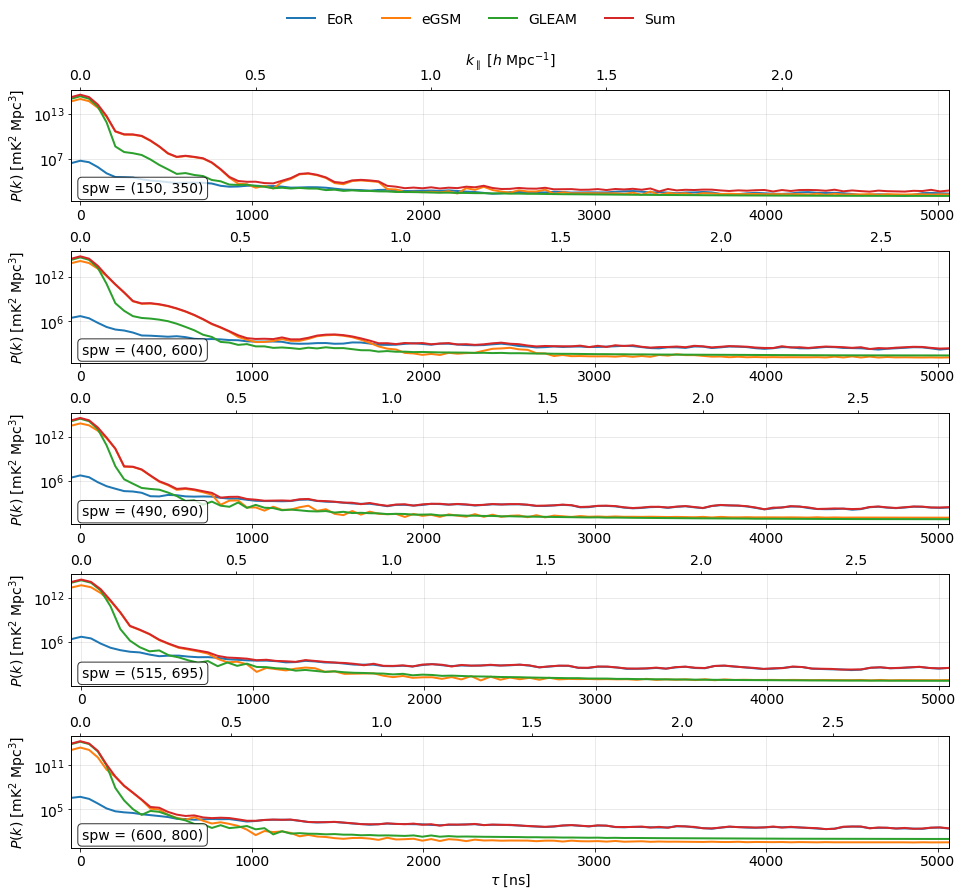

In [32]:
bl = params['bls'][0]
plot_time_averaged_delay_spectra(uvp_dic, metadata_dic, params, bl=bl)

**Figure 8** | Delay spectra per spw showing the various components' (EoR, eGSM, GLEAM + Brights) contributions to the delay spectrum.

## In-painting Efficacy Analysis

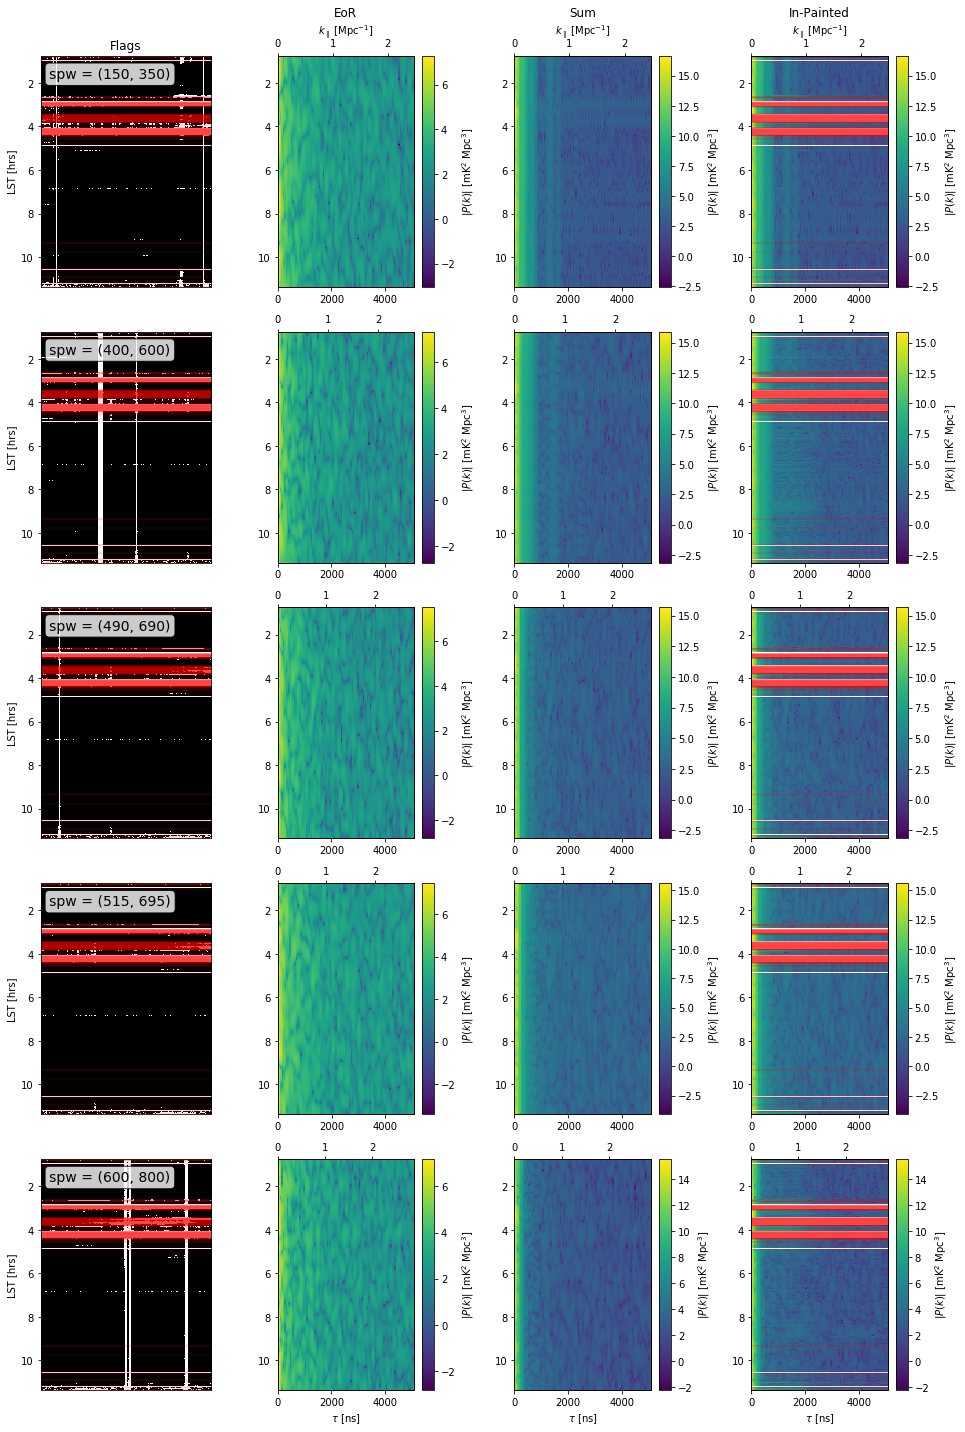

In [33]:
bl = params['bls'][0]
plot_pspec_waterfalls(bl, uvp_dic, params, metadata_dic, use_clean_flags=True, inp_data_dic=inp_data_dic)

**Figure 9** | Power spectrum waterfalls from $\texttt{hera_pspec}$ for a {{bl_dic[params['bls'][0]]}} baseline.  Each row corresponds to a given spectral window (identified by the text box in the top left corner of the leftmost plot) and from left to right are plotted the flags and the power spectra for the EoR, summed data, and in-painted summed data.  The red horizontal lines overlaid on the rightmost plot show those integrations which have been fully flagged by the in-painting analysis.

The plots below compare the recovered and true delay power spectra obtained from the in-painted and unflagged datasets, respectively.  Each row corresponds to a spectral window and contains, from left to right, a plot of:
 - Flags:
   * Flagged and unflagged data plotted in white and black, respectively
   * Integrations that are flagged during in-painting are overlaid in red
   * These flags incluse the LST cuts being used in the IDR2.2 analysis
   
 - Delay power spectra:
   * EoR power spectrum plotted as the dotted, colored line
   * True power spectrum plotted as the dashed, black line
   * Recovered power spectrum plotted as the solid, colored line   
   * The white region marks the extent in delay space that is used by the in-painting and is set by the `max_delay` parameter in this case.  The grey region represents the region in delay-space that is not touched by the in-painting model.
   
 - Residuals:
   * |Data| - |CLEANed Data| shows where the differences in the in-painted data lie in the spectral window

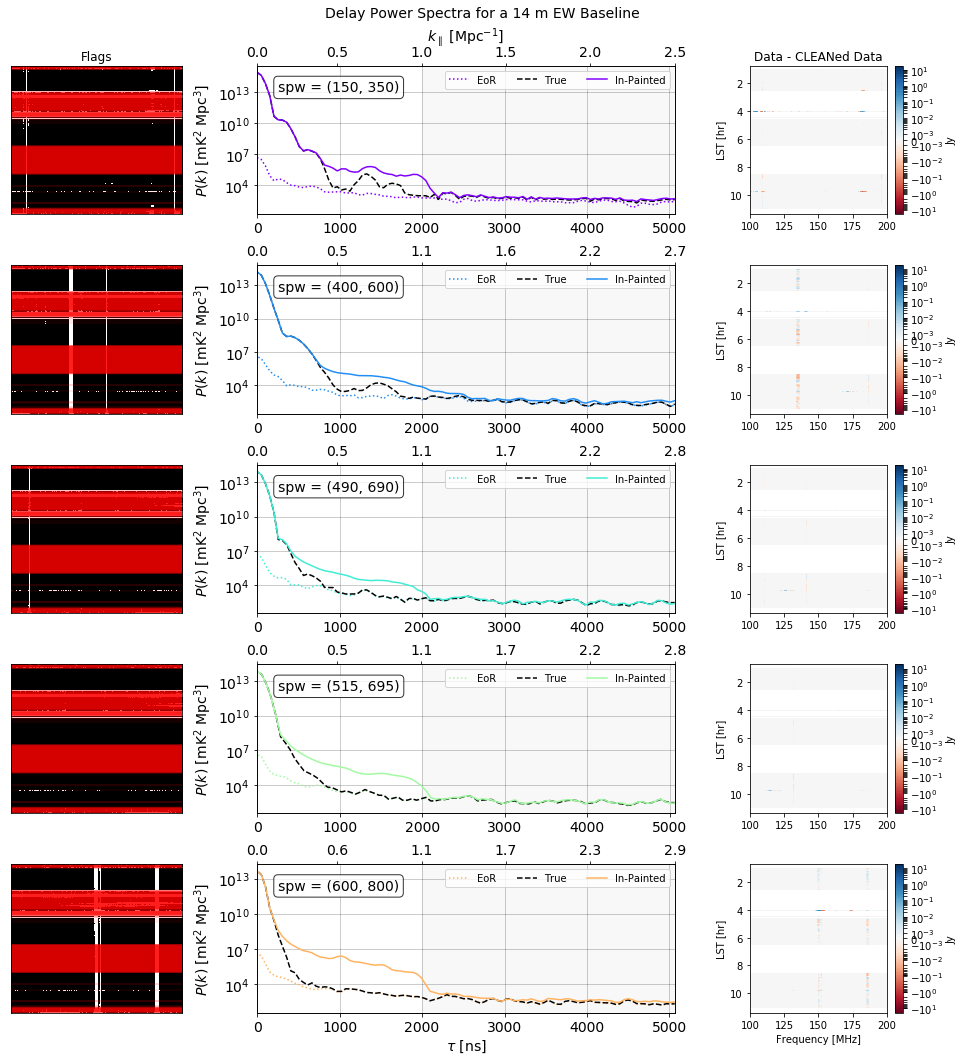

In [34]:
bl = params['bls'][0]
plot_time_averaged_pspec_spectra_with_flags_and_residuals(uvp_dic, params,
                                                          metadata_dic, inp_data_dic,
                                                          bl=bl, bl_dic=bl_dic, max_flag_occupancy=None,
                                                          symlog=True, linthresh=1.0e-3, linscale=0.5)

**Figure 9** | Flags (left column), LST averaged delay power spectra over the range of 0.7 - 11.4 hours of LST (center column), and RIMEz visibilities minus in-painted visibilities (right column) for various spws (rows).  In the center column, the dashed black line marks the "true" delay power spectrum calculated from the raw RIMEz visiblities with no flags applied, the solid colored line marks the recovered delay power spectrum from the in-painted visibilities, and the dotted colored line marks the delay power spectrum of the EoR visibilities.  The integrations that were __not__ used in the time-averaging are highlighted in red in the left column.  The grey region marks delays $\geq$ `min_dly` and marks the region in delay space that is not used by the `vis_clean` CLEAN components.

The performance of the in-painting process is largely dependent upon the number and distribution of flags within a given spw.  Some integrations are fully flagged for all frequencies by the `vis_clean` function if the percentage of flags within the spw at a particular time is greater than the `skip_wgt` parameter.  Others are flagged based on the chosen LST cuts from the IDR2.2 analysis team.  It's worthwhile, however, to try imposing further cuts based on flagging occupancy in a particular spw and integration.  In general, an integration with a larger flag occupancy will potentially produce larger residuals during in-painting that can contaminate the power spectrum.  In the cell below, we repeat the process of creating Figure 9 but impose a stricter cut that any integration with a flag occupancy > 10% **not** be included in the averaging of the delay power spectrum over time.

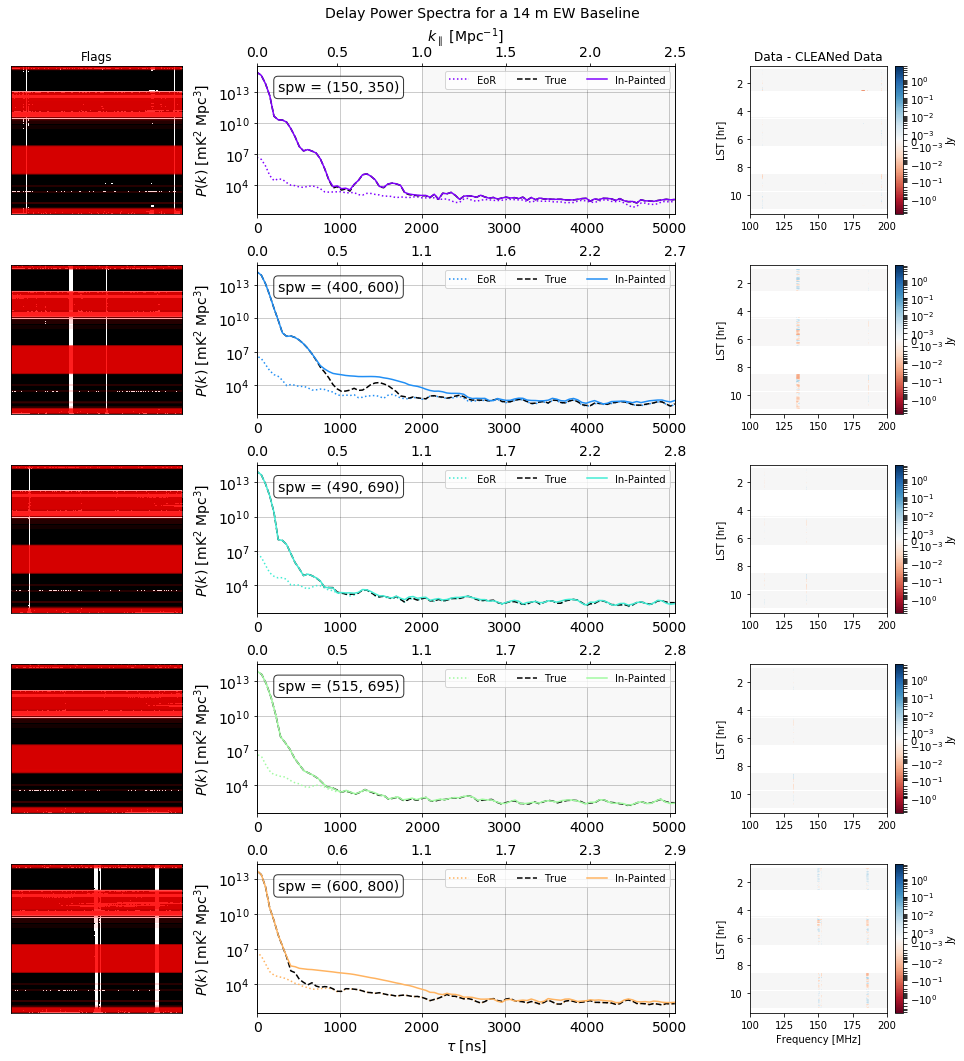

In [35]:
bl = params['bls'][0]
plot_time_averaged_pspec_spectra_with_flags_and_residuals(uvp_dic, params,
                                                          metadata_dic, inp_data_dic,
                                                          bl=bl, bl_dic=bl_dic,
                                                          max_flag_occupancy=0.1,
                                                          symlog=True, linthresh=1.0e-3, linscale=0.5)

**Figure 10** | Delay power spectra for a 14 m EW baseline averaged in time across 0.74 - 11.4 hours of LST using only integrations with $\leq$ 10% flag occupancy.  The columns and rows follow the formatting of Figure 9.

Given the large dynamic range of the power spectrum plots above, discerning how much the recovered power spectra differ from their true counterparts is tricky by eye.  To address this, we can look at the fractional error of the recovered power spectra relative to the true power spectrum computed via the time averaged delay power spectra as

$$
\large
\rm{Fractional\ Error}\
=\ \frac{P(k)_{recovered}^{time\ avg} - P(k)_{true}^{time\ avg}}{P(k)_{true}^{time\ avg}}
$$

The function below summarizes the performance of the in-painting in this particular application as a function of spw / flagging pattern (columns).  Similar to Figures 9 and 10, the flags with the excluded integrations are plotted for reference in the top row.  The fractional error for various baseline types is plotted in the middle row versus delay ($\tau$) and $k_\parallel$.  The bottom row shows the dynamic range achieved in recovery before the fractional error of the recovered power spectrum meets or exceeds 10% as the black points.  The light gray points show the dynamic range for each baseline type for all spws for comparison.

In [36]:
def plot_frac_error_deviation(uvp_dic,
                              params,
                              metadata_dic,
                              bl_dic,
                              max_flag_occupancy=None,
                              frac_err_thresh=0.1,
                              max_delay_ns=2000.0,
                              vmax=0.5,
                              spw_order=None):
    uvf = metadata_dic['flags']
    lsts_hrs = metadata_dic['lsts_hrs']
    freqs = metadata_dic['freqs']
    spws = params['spws']
    if not spw_order is None:
        spws = [spws[i] for i_spw in spw_order]
    ntimes = lsts_hrs.size
    nspws = len(spws)
    flag_array = uvf.flag_array[:, 0, :, 0]

    fontsize = 14

    # Setup boolean array for LST cuts
    lst_cut_ints = np.zeros(lsts_hrs.size).astype('bool')
    for lst_range in params['lst_cuts']:
        lst_inds = np.logical_and(lsts_hrs >= lst_range[0],
                                  lsts_hrs <= lst_range[1])
        lst_cut_ints += lst_inds
    # Invert to flag the LSTs we don't want
    lst_cut_ints = ~lst_cut_ints
    
    # Set up stats array
    uvp_avg = {}
    bl = params['bls'][0]
    bl_key = bl + ('ee',)
    for key in uvp_dic.keys():
        # Extract uvpspec object from uvps dic
        uvp_avg[key] = copy.deepcopy(uvp_dic[key])

        for i_spw, spw in enumerate(spws):
            ps_key = (i_spw, (bl, bl), 'xx')

            # Need to pull the integrations where the flagging criterion is not met
            # i.e. bad_ints = 1.0 for integrations we do NOT want to use
            if not max_flag_occupancy is None:
                flags_spw = flag_array[:, spw[0]:spw[1]]
                bad_ints = np.sum(flags_spw, axis=1) > 0.1 * (spw[1] - spw[0])
                bad_ints += ~uvp_dic['recovered'].get_integrations(ps_key).astype('bool')
            else:
                bad_ints = ~uvp_dic['recovered'].get_integrations(ps_key).astype('bool')

            # Combine with the LST cuts
            bad_ints += lst_cut_ints

            # Reshape into (ntimes, ndlys)
            bad_ints = np.repeat(bad_ints[:, np.newaxis], spw[1] - spw[0], axis=1)

            # Set stats array for each bl pair in uvp
            for blp in uvp_avg[key].get_blpairs():
                uvp_avg[key].set_stats('bad_ints', (i_spw, blp, 'xx'), bad_ints)

        # Average delay spectra over time using bad_ints as weights
        uvp_avg[key].average_spectra(time_avg=True, error_weights='bad_ints')

    fig = plt.figure(figsize=(4 * nspws + 1, 10))
    gs = GridSpec(3, nspws + 1, width_ratios=[1.0] * nspws + [0.15])

    # frac_errs = np.zeros((nspws, len(blps), delays.size))
    blps = uvp_avg['eor'].get_blpairs()
    nblps = len(blps)
    frac_errs_allspws = []
    thresh_inds = np.zeros((nspws, len(blps)), dtype='int')
    dynamic_ranges = np.zeros_like(thresh_inds).astype('float')

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_ax, i_spw in enumerate([4, 1, 2, 0, 3]):
            spw = spws[i_spw]

            # Plot flags for spw
            ax = fig.add_subplot(gs[0, i_ax])
            cax = ax.imshow(flag_array[:, spw[0]:spw[1]].astype('int'),
                            cmap='bone', aspect='auto', origin='upper',
                            extent=[spw[0], spw[1], lsts_hrs.max(), lsts_hrs.min()])
            ax.hlines(lsts_hrs[bad_ints[:, 0]], spw[0], spw[1],
                      linestyle='-', alpha=0.1, color='r')
            ax.set_xticks([])
            if i_ax == 0:
                ax.set_ylabel('LST [hrs]')
            else:
                ax.set_yticks([])
            ax.set_title('spw = {}'.format(spw))

            # Get delays and kparas
            delays = uvp_avg[key].get_dlys(i_spw) * 1.0e9
            ndlys = delays.size
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            kparas = delays * 1.0e-09 * tau_to_kpara

            # Plot delay power spectrum for spw
            ax = fig.add_subplot(gs[1, i_ax])

            delays_xlim = [delays[delays.size//2], max_delay_ns]
            max_delay_ind = np.argmin(np.abs(delays - max_delay_ns))
            kparas_xlim = [kparas[kparas.size//2], kparas[max_delay_ind]]
            tick_inds = np.linspace(delays.size//2, max_delay_ind, 6).astype('int')

            # Collect the delay for each blpair at which the
            # fractional error exceeds `frac_err_thresh`
            blps = uvp_avg['sum'].get_blpairs()
            blps = [blps[i] for i in [0, 2, 1, 3, 4]]

            frac_errs = np.zeros((len(blps), delays.size))
            for i_blp, blp in enumerate(blps):
                recovered_ps = uvp_avg['recovered'].get_data((i_spw, blp, 'xx'))[0].real
                true_ps = uvp_avg['sum'].get_data((i_spw, blp, 'xx'))[0].real

                frac_errs[i_blp] = (recovered_ps - true_ps) / true_ps
                thresh_inds[i_spw, i_blp] = np.where(frac_errs[i_blp, delays.size//2:]
                                                     > frac_err_thresh)[0][0]
                dynamic_ranges[i_spw, i_blp] = (
                    recovered_ps[ndlys//2]
                    / recovered_ps[ndlys//2 + thresh_inds[i_spw, i_blp]]
                    )

            frac_errs_allspws.append(frac_errs)

            extent = [delays.min(), delays.max(), -0.5, len(blps) - 0.5]
            cax = ax.imshow(frac_errs, extent=extent, origin='lower',
                            vmin=0.0, vmax=vmax, aspect='auto')
            ax.set_yticks(np.arange(0, len(blps)))

            if i_ax == 0:
                ax.set_yticklabels([bl_dic[blp[0]] for blp in blps])
                ax.set_ylabel('Baseline Type', labelpad=10)
            else:
                ax.set_yticklabels([])

            ax.set_xlabel(r'$\tau$ [ns]')

            # Secondary axis for kparallel ticks
            ax2 = plt.twiny(ax)
            ax2.set_xlim(kparas_xlim)
            ax2.set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]', fontsize=fontsize)

            ax.set_xlim(delays_xlim)

        for i_ax, i_spw in enumerate([4, 1, 0, 2, 3]):
            ax = fig.add_subplot(gs[2, i_ax])
            for i in range(nspws):
                ax.plot(dynamic_ranges[i], np.arange(len(blps)), 'o', c='0.5', alpha=0.25)
            ax.plot(dynamic_ranges[i_spw], np.arange(len(blps)), 'o', c='k')
            if i_ax == 0:
                ax.set_yticks(np.arange(len(blps)))
                ax.set_yticklabels([bl_dic[blp[0]] for blp in blps], rotation=0)
                ax.set_ylabel('Baseline Type', labelpad=10)
            else:
                ax.set_yticklabels([])
            ax.set_xlabel('Dynamic Range')
            ax.set_xscale('log')
            ax.grid(which='both', alpha=0.1)        

        ax = fig.add_subplot(gs[1, nspws])
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cbax = divider.append_axes("left", size="75%")
        fig.colorbar(cax, cax=cbax, label='Fractional Error', extend='max')

        gs.tight_layout(fig)
        gs.update(wspace=0.1)

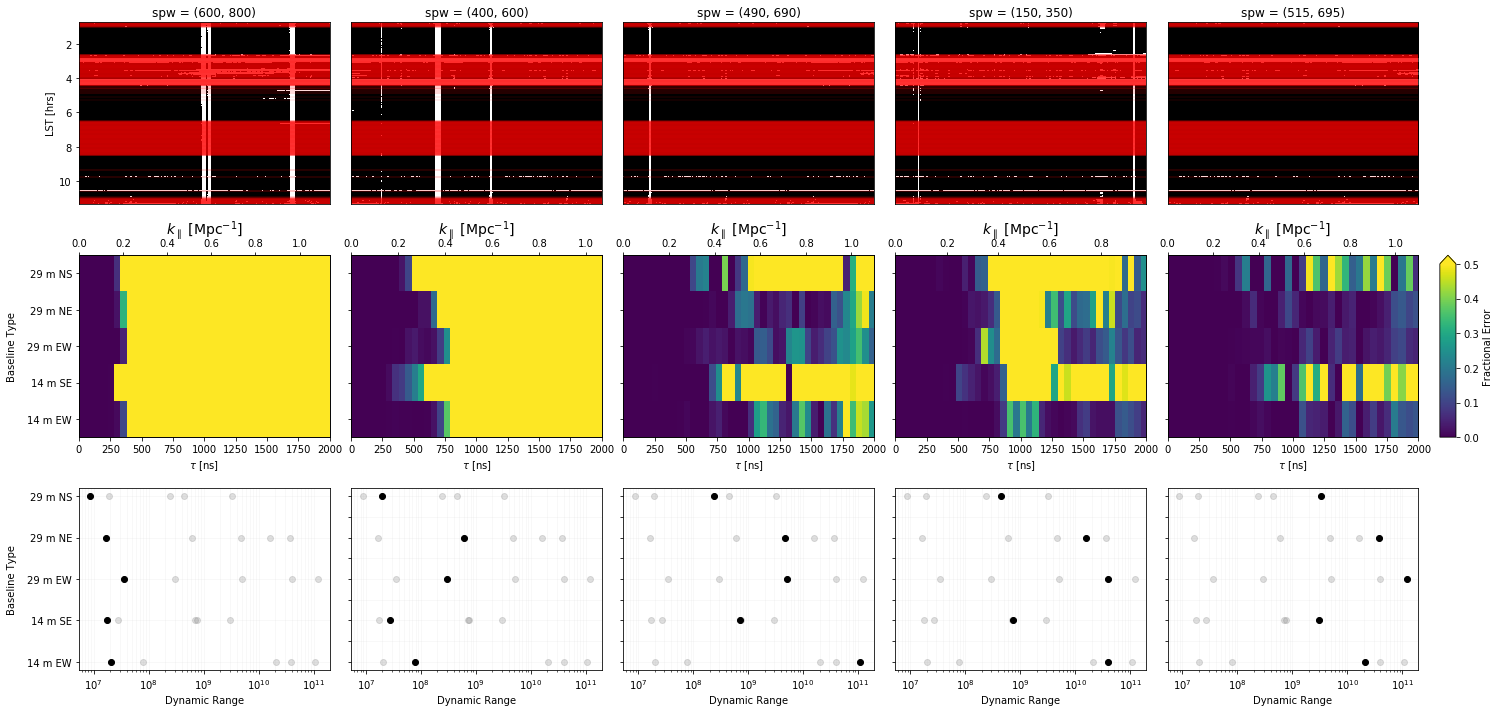

In [39]:
plot_frac_error_deviation(uvp_dic,
                          params,
                          metadata_dic,
                          bl_dic,
                          max_flag_occupancy=0.1,
                          frac_err_thresh=0.1,
                          max_delay_ns=2000.0,
                          vmax=0.5,
                          spw_order=None)

**Figure 11** | Each column corresponds to a different spectral window indexed by the corresponding frequency channel indices.  The top row shows the flags present in the data with white and black pixels marking flagged and unflagged samples, respectively.  The horizontal red lines over-plotted on the flags show the integrations that were not used in the time averaging due to flagging from the in-painting process, additional flagging based on flag occupancy within the spectral window, and LST cuts being made by the IDR2.2 analysis team.  The middle row shows the fractional error of the recovered power spectrum from the in-painted data relative to the true, unflagged data.  The bottom row shows the dynamic range achieved by the in-painting, i.e. how far down in the power spectrum relative to the peak at $\tau$ = 0 ns the in-painted power spectrum is able to probe before deviating from the true power spectrum by 10\%.  Black points correspond to the dynamic range values per baseline type in a given spectral window.  Grey points show the dynamic range of each baseline type across all spectral windows for reference.